In [1]:
# Ensure you run this at the beginning of the notebook
%matplotlib notebook

from pynq import Overlay
from pynq import allocate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output

# Load the bitstream
ol = Overlay("dma.bit")  # Replace with the path to your bitstream file



In [2]:
print("Available IPs in the overlay:")
for ip_name in ol.ip_dict:
    print(ip_name)

Available IPs in the overlay:
axi_dma


In [3]:
# Data size (assuming each buffer has TOTAL_SAMPLES)
data_size = 1024

# Access the DMA
dma = ol.axi_dma

In [4]:
dma.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

<IPython.core.display.Javascript object>


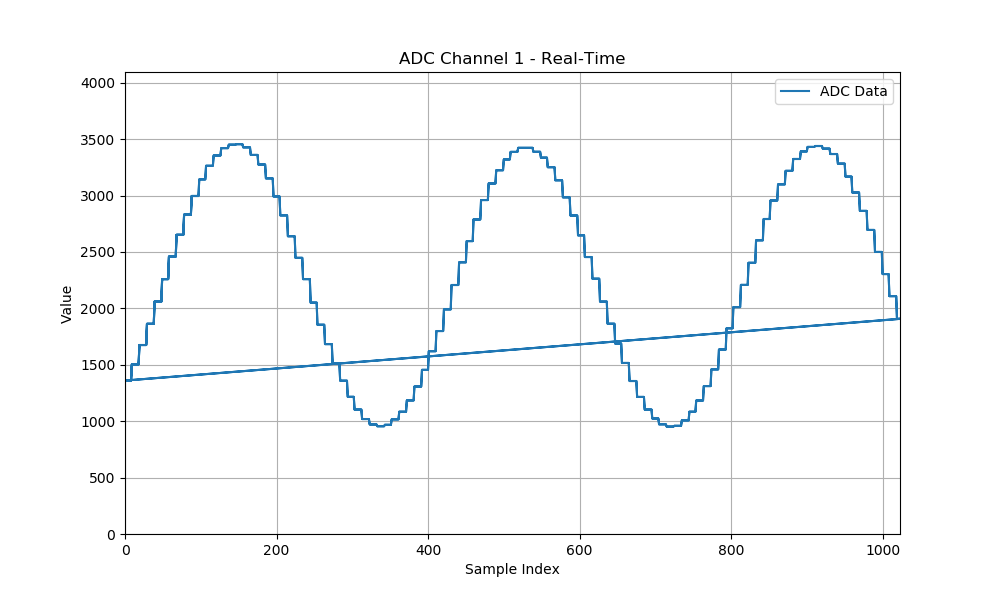

In [5]:


# Allocate buffers for the data received from DMA
output_buffer_0 = allocate(shape=(data_size,), dtype=np.uint32)  # Buffer for first memory bank
output_buffer_1 = allocate(shape=(data_size,), dtype=np.uint32)  # Buffer for second memory bank

# Select the receive channel from DMA
dma_recv = dma.recvchannel

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], label="ADC Data")
ax.set_xlim(0, data_size - 1)
ax.set_ylim(0, 4095)  # Assuming 12-bit ADC data, adjust as needed
ax.set_title("ADC Channel 1 - Real-Time")
ax.set_xlabel("Sample Index")
ax.set_ylabel("Value")
ax.grid(True)
ax.legend()

# Initialize the data
xdata, ydata = [], []

# Function to initialize the plot (needed for FuncAnimation)
def init():
    line.set_data([], [])
    return line,

# Update function for FuncAnimation
def update(frame):
    global output_buffer_0, output_buffer_1, dma_recv
    
    # Alternate between the two memory banks
    if frame % 2 == 0:
        # Transfer data from the first memory bank
        dma_recv.transfer(output_buffer_0)
        dma_recv.wait()
        processed_data = output_buffer_0 & 0x0FFF  # Process data (12-bit)
    else:
        # Transfer data from the second memory bank
        dma_recv.transfer(output_buffer_1)
        dma_recv.wait()
        processed_data = output_buffer_1 & 0x0FFF  # Process data (12-bit)
    
    # Update xdata and ydata
    xdata.append(frame)
    ydata.append(processed_data[frame % data_size])  # Wrap around after data_size

    # Update the plot with new data
    line.set_data(xdata, ydata)
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(data_size), init_func=init, blit=True, interval=1)

# Display the animation
plt.show()
